## Analysis of measured MWA dipole pattern on 25 April 2021 at Meyer's Park

### Mapping run 1 

Start time: 8:26AM (AZ Time)

flight path generated around lat: 33.39950479, lon: -111.91540414, radius = 35m

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ECHO
from glob import glob
import healpy as hp
import pandas as pd
import glob
import os
import pytz 
from scipy.interpolate import interp1d
from astropy.time import Time
from ECHO import plot_utils
from ECHO.plot_utils import grid_to_healpix, make_polycoll,project_healpix,fmt,nf,cmap_discretize,get_interp_val
from ECHO.position_utils import latlon2xy,to_spherical
from matplotlib import ticker,cm

In [2]:
ulogdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/25_April_2021_second_attempt/25_April_2021_flightlogs/25_April_2021_flightlogs/'
rxdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/25_April_2021_second_attempt/25_April_2021_fieldfox_data/Mapping_run/'

In [3]:
os.listdir(ulogdir)

['2021-04-25 08-21-14.csv',
 '2021-04-25 08-21-14.tlog',
 '2021-04-25 08-21-14.txt',
 'log_28_2021-4-25-07-06-08.ulg',
 'log_29_2021-4-25-07-51-04.ulg',
 'log_30_2021-4-25-08-50-44.ulg']

### Ulog recorded during the first mapping run: log_30_2021-4-25-08-50-44.ulg

In [4]:
help(ECHO.read_utils.read_ulog)

Help on function read_ulog in module ECHO.read_utils:

read_ulog(ulog, output=None, messages='vehicle_global_position,vehicle_local_position,vehicle_gps_position')
    Read in ulog file, put them into appropriate arrays, then save to .csv
    
    Input:
        ulog (int): the ulog to be converted.
    
    Output:
        global_array: global position.
        local_array: local position.
        gps_array: gps raw data.



In [5]:
global_arr , local_arr, gps_arr = ECHO.read_utils.read_ulog(ulogdir+'log_30_2021-4-25-08-50-44.ulg')

<IPython.core.display.Javascript object>


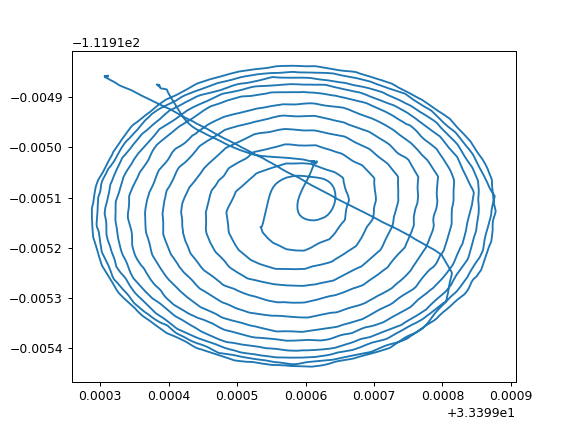

In [6]:
plt.figure()
plt.plot(global_arr[:,1], global_arr[:,2])

In [ ]:
local_arr[0], gps_arr[0]

### Adding bootstart 

global array headers: timestamp(s from boot)    lat(deg)    lon(deg)    alt(m above ground)    yaw(deg)

local array headers: timestamp(s from boot)    reftime    reflat(deg)    reflon(deg)    x(m)    y(m)    z(m)    yaw(deg)    refalt(m above sea)

gps array headers: timestamp(s from boot)    utctime(s from epoch)    lat(deg)    lon(deg)    alt(m above sea)

In [7]:
bootstart = gps_arr[0][1]-gps_arr[0][0]
global_arr[:,0] = global_arr[:,0]+ bootstart
local_arr[:,0] = local_arr[:,0]+bootstart
local_arr = np.delete(local_arr,1,1)
gps_arr[:,0] = gps_arr[:,0]+bootstart
gps_arr = np.delete(gps_arr,1,1)

In [8]:
time = Time(global_arr[:,0], format = 'unix', scale = 'utc')

In [9]:
global_arr.shape, gps_arr.shape, local_arr.shape

((7827, 5), (1553, 4), (15761, 8))

### Plotting altitudes from all three position arrays

What to expect?

alts from global array and gps array should be elevations from sea level in meters. Tempe is at ~360m elevations. 

alts from local array should show elevation from ground. so a range of 0-35m

<IPython.core.display.Javascript object>


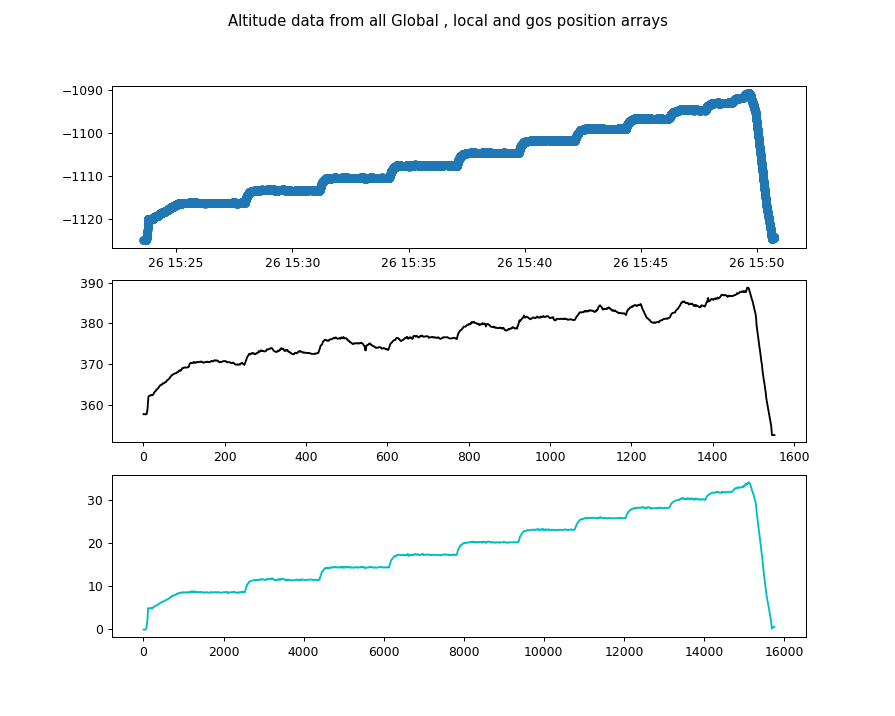

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize= (10,8))
fig.suptitle('Altitude data from all Global , local and gps position arrays')
ax1.plot_date(time.plot_date,global_arr[:,3])
ax2.plot(gps_arr[:,-1],'k')
ax3.plot(local_arr[:,5], 'c')

### Reading in rx data

In [16]:
rx_files = glob.glob(rxdir + '/*.csv')

In [20]:
final_df = []
for file in rx_files:
    print(file)
    data = pd.read_csv(file,skiprows = 17,header=None) #skpiing all the headers 
    data=data.drop([0,2,3,4],axis=1) # dropping nan values
    with open(file,'r') as f:
        for i,line in enumerate(f):
            if 'Freq Hz' in line: 
                break
    cols=line.split(',')[5:]
    cols = ['Datetime'] + cols #making a dataframe that has Datetime and power 
    data.columns=cols
    final_df.append(data)

/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/25_April_2021_second_attempt/25_April_2021_fieldfox_data/Mapping_run/0.csv


/home/mrudula/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/25_April_2021_second_attempt/25_April_2021_fieldfox_data/Mapping_run/1.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/25_April_2021_second_attempt/25_April_2021_fieldfox_data/Mapping_run/2.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/25_April_2021_second_attempt/25_April_2021_fieldfox_data/Mapping_run/3.csv


In [21]:
rx_data = pd.concat(final_df,ignore_index=True)

In [22]:
rx_data['Datetime'] = pd.to_datetime(rx_data['Datetime'])
rx_times = Time(rx_data['Datetime'], format = 'datetime64', scale = 'utc')
rx_times.iso

masked_array(data=['2021-04-25 08:18:29.162', '2021-04-25 08:18:29.361',
                   '2021-04-25 08:18:29.561', ...,
                   '2021-04-25 08:44:18.263', '2021-04-25 08:44:18.463',
                   --],
             mask=[False, False, False, ..., False, False,  True],
       fill_value='N/A',
            dtype='<U23')

<IPython.core.display.Javascript object>


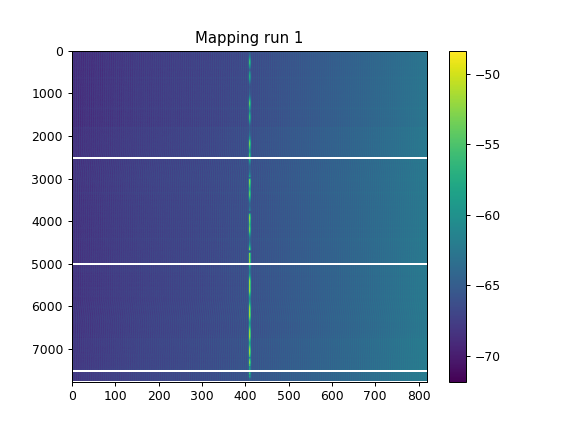

In [23]:
plt.figure()
plt.imshow(rx_data.iloc[:,2:], aspect = 'auto')
plt.title('Mapping run 1')
plt.colorbar()

<IPython.core.display.Javascript object>


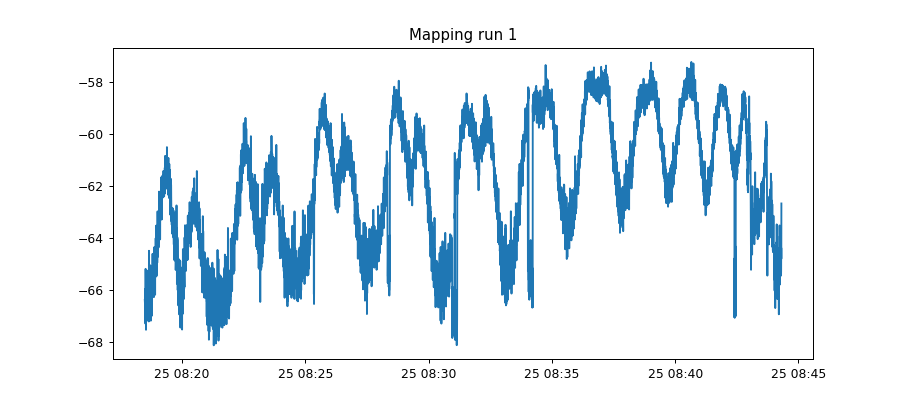

Text(0.5, 1.0, 'Mapping run 1')

In [24]:
plt.figure()
plt.plot(rx_data['Datetime'],rx_data.iloc[:,409])
plt.title('Mapping run 1')
#plt.plot(global_arr[:,3])

### Flagging take off and landing.

To do that, we need waypoint data from Tlogs.  

Since we don't have a tlog file associated with this ulog, I manually times from looking at the drone altitude vs time plot

In [27]:
start_time = '2021-04-25 15:25:00'
end_time = '2021-04-25 15:49:00'
flagged_drone_pos = time[(time.iso >= start_time) & (time.iso <= end_time)]
flagged_global_arr = global_arr[(time.iso >= start_time) & (time.iso <= end_time)]

In [28]:
flagged_global_arr.shape , flagged_drone_pos.shape

((6921, 5), (6921,))

<IPython.core.display.Javascript object>


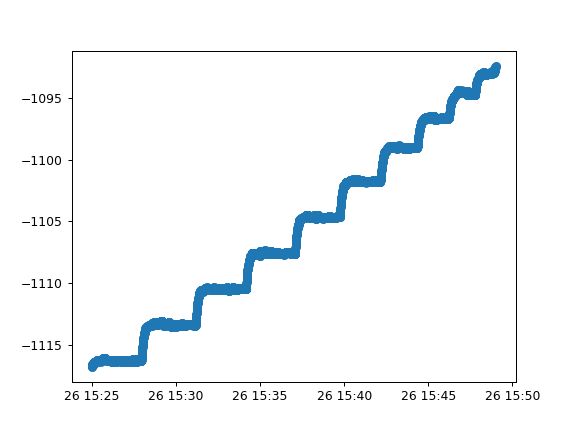

[]

In [29]:
plt.figure()
plt.plot_date(flagged_drone_pos.plot_date,flagged_global_arr[:,3])
plt.plot()

In [30]:
#converting local times in rx data to utc
rx_times_v2 = rx_data['Datetime'].dt.tz_localize('US/Arizona').dt.tz_convert('utc')
rx_times_v2.tail(5)

7763   2021-04-25 15:44:17.864000+00:00
7764   2021-04-25 15:44:18.064000+00:00
7765   2021-04-25 15:44:18.263000+00:00
7766   2021-04-25 15:44:18.463000+00:00
7767                                NaT
Name: Datetime, dtype: datetime64[ns, UTC]

In [31]:
timezone = pytz.timezone("US/Arizona")
flagged_drone_pos_with_t = [timezone.localize(flagged_drone_pos.datetime[x]) for x in range(len(flagged_drone_pos.datetime))]

In [32]:
flagged_rx = rx_data[(rx_times_v2 <= flagged_drone_pos_with_t[0]) & 
                     (rx_times_v2 >= flagged_drone_pos_with_t[-1])]
flagged_rx

,Datetime,68000000,68004878.0487805,68009756.097561,68014634.1463415,68019512.1951219,68024390.2439024,68029268.2926829,68034146.3414634,68039024.3902439,...,71956097.5609741,71960975.6097546,71965853.6585351,71970731.7073156,71975609.7560961,71980487.8048766,71985365.8536571,71990243.9024375,71995121.951218,71999999.9999985\n


In [33]:
#another way to do this 
temp_df = pd.DataFrame({'a':range(global_arr.shape[0])})
temp_df['date'] = global_arr[:,0]
temp_df['date'] = pd.to_datetime(temp_df['date'],unit='s')

In [34]:
drone_times = temp_df['date'].dt.tz_localize('utc')
flagged_drone_times = drone_times[(time.iso >= start_time) & (time.iso <= end_time)]

In [35]:
flagged_drone_times.iloc[0], rx_times_v2.iloc[0]

(Timestamp('2021-04-25 15:25:00.162063837+0000', tz='UTC'),
 Timestamp('2021-04-25 15:18:29.162000+0000', tz='UTC'))

In [36]:
flagged_rx_times = rx_times_v2[(rx_times_v2 >= flagged_drone_times.iloc[0]) & 
                     (rx_times_v2 <= flagged_drone_times.iloc[-1])]
flagged_rx_times

1960   2021-04-25 15:25:00.328000+00:00
1961   2021-04-25 15:25:00.528000+00:00
1962   2021-04-25 15:25:00.728000+00:00
1963   2021-04-25 15:25:00.927000+00:00
1964   2021-04-25 15:25:01.127000+00:00
                     ...               
7762   2021-04-25 15:44:17.665000+00:00
7763   2021-04-25 15:44:17.864000+00:00
7764   2021-04-25 15:44:18.064000+00:00
7765   2021-04-25 15:44:18.263000+00:00
7766   2021-04-25 15:44:18.463000+00:00
Name: Datetime, Length: 5804, dtype: datetime64[ns, UTC]

In [37]:
flagged_rx = rx_data[(rx_times_v2 >= flagged_drone_times.iloc[0]) & 
                     (rx_times_v2 <= flagged_drone_times.iloc[-1])]

<IPython.core.display.Javascript object>


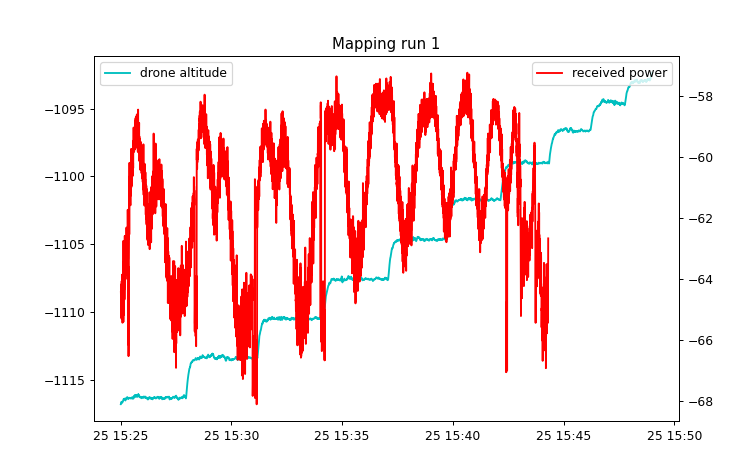

Text(0.5, 1.0, 'Mapping run 1')

In [39]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot(flagged_rx_times, flagged_rx.iloc[:,409], 'r', label = 'received power')
ax.plot(flagged_drone_times, flagged_global_arr[:,3], 'c', label = 'drone altitude')
ax.legend()
ax2.legend()
plt.title('Mapping run 1')

In [ ]:
#rx_times_v2 <= flagged_drone_pos.datetime[-1]

In [ ]:
# temp_df = pd.DataFrame({'a':range(global_arr.shape[0])})
# temp_df['date'] = global_arr[:,0]
# temp_df['date'] = pd.to_datetime(temp_df['date'],unit='s')

In [ ]:
# rx_times_v2 <= temp_df['date'].dt.tz_localize('US/Arizona').iloc[-1]

In [ ]:
# rx_times_v2 <= with_timezone[-1]

### interpolate rx at drone positions 

In [40]:
#we only have receiver data until 15:45 utc or 8:45am local time 
#getting drone position data
drone_times_corr_rx = flagged_drone_times[flagged_drone_times <= flagged_rx_times.iloc[-1]]
drone_pos_corr_rx = flagged_global_arr[flagged_drone_times <= flagged_rx_times.iloc[-1]]

In [41]:
drone_pos_corr_rx.shape , flagged_rx.iloc[:,409].shape

((5567, 5), (5804,))

<IPython.core.display.Javascript object>


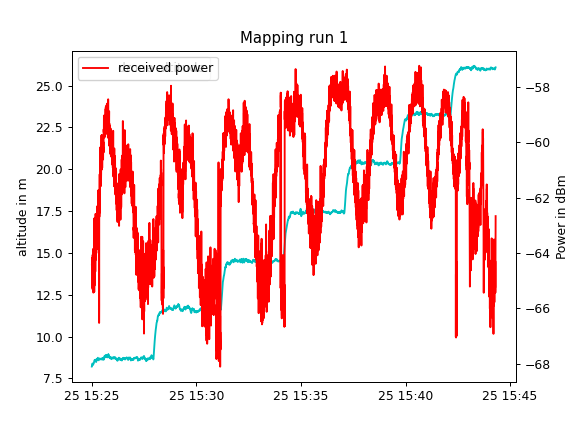

In [42]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot(flagged_rx_times, flagged_rx.iloc[:,409], 'r', label = 'received power')
ax.plot(drone_times_corr_rx, drone_pos_corr_rx[:,3]+1125, 'c', label = 'drone altitude')
ax2.set_ylabel('Power in dBm')
ax.set_ylabel('altitude in m')
ax.legend()
plt.title('Mapping run 1')
plt.legend()

In [43]:
def interp_rx(postimes,rxtimes,rx):
    power_interp_model = interp1d(rxtimes.gps,rx,bounds_error = False)
    rx_interp = power_interp_model(postimes.gps)
    return rx_interp

In [44]:
interpolated_rx = interp_rx(Time(drone_times_corr_rx),Time(flagged_rx_times),flagged_rx.iloc[:,409])

In [45]:
drone_times_corr_rx.shape, interpolated_rx.shape

((5567,), (5567,))

<IPython.core.display.Javascript object>


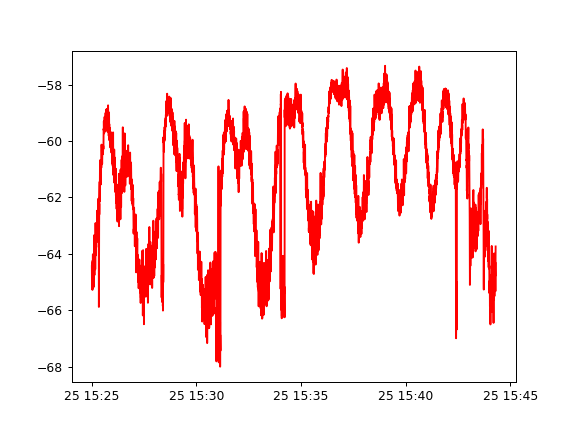

In [46]:
plt.figure()
plt.plot(drone_times_corr_rx,interpolated_rx, 'r')

In [47]:
alts = drone_pos_corr_rx[:,3]+1125 #global alts are off by +1125. need to figure out why
lat0 = 33.39950479 #used to generate flight path
lon0 = -111.9154014 #used to generate flight path
hpx_beam,hpx_rms,hpx_counts = grid_to_healpix(drone_pos_corr_rx[:,1],
                                              drone_pos_corr_rx[:,2],
                                              alts,
                                              interpolated_rx,
                                              lat0,lon0,nside = 8)

/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:169: RuntimeWarning: invalid value encountered in sqrt
  rms *= (1+1./np.sqrt(2*(counts-1)))
/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:169: RuntimeWarning: divide by zero encountered in true_divide
  rms *= (1+1./np.sqrt(2*(counts-1)))
/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:169: RuntimeWarning: invalid value encountered in multiply
  rms *= (1+1./np.sqrt(2*(counts-1)))


In [48]:
hpx_beam[np.where(np.isnan(hpx_beam))[0]] = hp.UNSEEN
hpx_counts[np.where(np.isnan(hpx_counts))[0]] = hp.UNSEEN
M = np.ma.array(hpx_beam,fill_value=hp.UNSEEN)
M = np.ma.masked_where(hp.UNSEEN==M,M)
M.fill_value = hp.UNSEEN
counts = hpx_counts
beam = M

In [49]:
beam -= beam.max() #normalizing

In [50]:
THETA,PHI,IM = project_healpix(beam)
X,Y = np.meshgrid(
        np.linspace(-1,1,num=THETA.shape[0]),
        np.linspace(-1,1,num=THETA.shape[1]))

/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/ECHO/plot_utils.py:100: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(1-X**2 - Y**2)


<IPython.core.display.Javascript object>


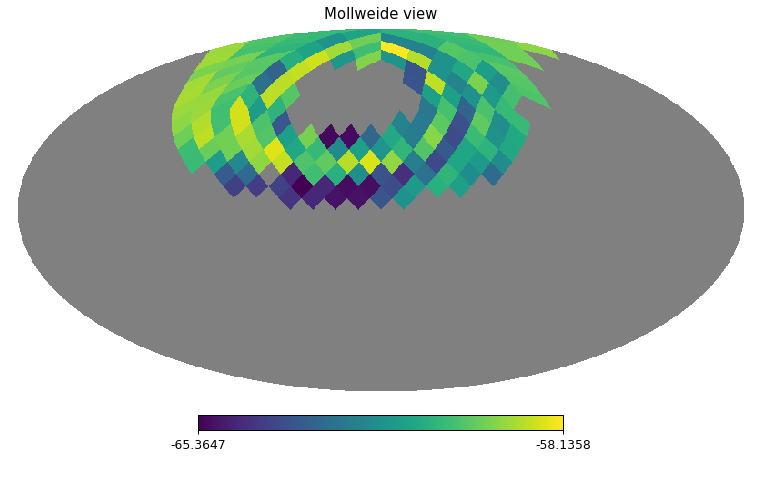

/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/mrudula/anaconda2/envs/ECHO/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future version

In [51]:
hp.mollview(hpx_beam)

<IPython.core.display.Javascript object>


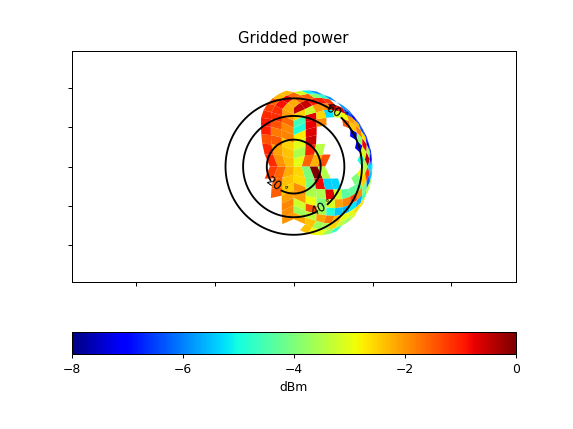

In [52]:
plt.figure()
ax1 = plt.subplot(111)
ax1.axis('equal')
beamcoll = plot_utils.make_polycoll(beam,cmap=matplotlib.cm.jet)
beamcoll.set_clim(-8,0)
ax1.add_collection(beamcoll)
CS = ax1.contour(X,Y,THETA*180/np.pi,[20,40,60],colors='k')
CS.levels = [plot_utils.nf(val) for val in CS.levels]
plt.clabel(CS, inline=1, fontsize=10,fmt=plot_utils.fmt)
ax1.autoscale_view()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_title('Gridded power')
cb = plt.colorbar(beamcoll, ax=ax1,orientation='horizontal')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('dBm')

In [53]:
radTheta=np.pi/2
alt =np.linspace(0, radTheta)
az =np.zeros_like(alt)
slice_E = plot_utils.get_interp_val(beam,alt,az)
slice_H = plot_utils.get_interp_val(beam,alt,az+np.pi/2)

<IPython.core.display.Javascript object>


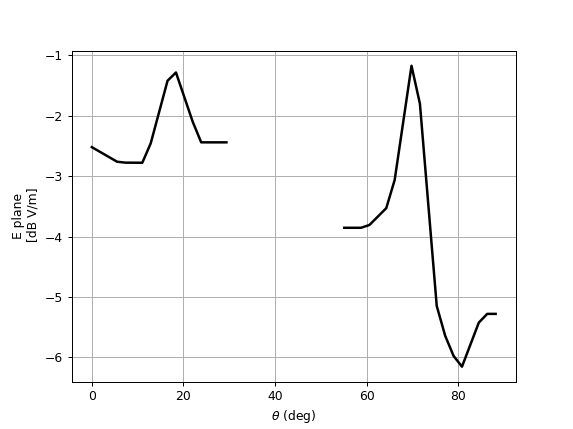

<IPython.core.display.Javascript object>


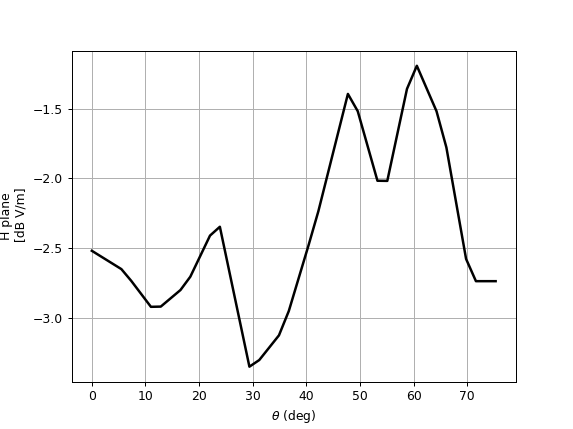

Text(0, 0.5, 'H plane\n [dB V/m]')

In [54]:
plt.figure()
plt.plot(alt*180/np.pi,slice_E,'-k',lw=2)
plt.grid()
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('E plane\n [dB V/m]')
plt.figure()
plt.plot(alt*180/np.pi,slice_H,'-k',lw=2)
plt.grid()
plt.xlabel('$\\theta$ (deg)')
plt.ylabel('H plane\n [dB V/m]')